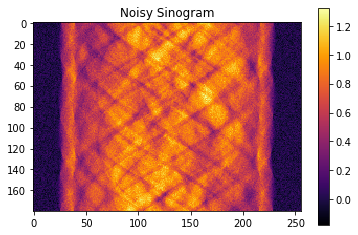

In [1]:
import numpy as np 
import numpy                          
import matplotlib.pyplot as plt

from ccpi.optimisation.algorithms import PDHG, SPDHG

from ccpi.optimisation.operators import BlockOperator, Identity, Gradient
from ccpi.optimisation.functions import ZeroFunction, L1Norm, \
                      MixedL21Norm, BlockFunction, L2NormSquared,\
                          KullbackLeibler, IndicatorBox, TotalVariation
from ccpi.framework import TestData, ImageGeometry, AcquisitionGeometry, BlockDataContainer, AcquisitionData
import os
import sys
from ccpi.plugins.regularisers import FGP_TV 
from ccpi.filters import regularisers
from ccpi.astra.operators import AstraProjectorSimple

import tomophantom
from tomophantom import TomoP2D
import functools

from ccpi.utilities.display import show

data_from_= "tomophantom"

if data_from_ == "cil":
    
    loader = TestData(data_dir=os.path.join(sys.prefix, 'share','ccpi'))
    data = loader.load(TestData.SIMPLE_PHANTOM_2D, size=(128,128))
    ig = data.geometry
    ig.voxel_size_x = 0.01
    ig.voxel_size_y = 0.01  
    
else:
    model = 12 # select a model number from the library
    N = 256 # set dimension of the phantom
    path = os.path.dirname(tomophantom.__file__)
    path_library2D = os.path.join(path, "Phantom2DLibrary.dat")

    phantom_2D = TomoP2D.Model(model, N, path_library2D)    
    ig = ImageGeometry(voxel_num_x = N, voxel_num_y = N, 
                       voxel_size_x = 0.01,
                       voxel_size_y = 0.01)
    data = ig.allocate()
    data.fill(phantom_2D) 
    
# Create acquisition data and geometry
detectors = data.shape[0]
angles = np.linspace(0, np.pi, 180)
ag = AcquisitionGeometry('parallel','2D',angles, detectors, pixel_size_h = 0.01)

np.random.seed(10)
Aop = AstraProjectorSimple(ig, ag, 'gpu')
sin = Aop.direct(data)
noisy_data = 0.*sin
noisy_data.fill(np.random.normal(0, 0.05, size = ag.shape) + sin.as_array())

plt.figure()
plt.imshow(noisy_data.as_array(), cmap = 'inferno')
plt.title('Noisy Sinogram')
plt.colorbar()
plt.show()
    
alpha = 0.1

In [9]:
# Explicit PDHG  # Devide arrays of 2 by voxel_size when voxels_size not 1.
f1 = 0.5 * L2NormSquared(b=noisy_data)
f2 = alpha * MixedL21Norm()
F = BlockFunction(f1, f2)
Grad = Gradient(ig)
K = BlockOperator(Aop, Grad)
G = IndicatorBox(lower=0)
normK = K.norm()

tmp_sigma = K.range_geometry().allocate()
tmp_sigma.get_item(0).fill(Aop.direct(Aop.domain_geometry().allocate(1)))
tmp_sigma.get_item(1).get_item(0).fill(Grad.domain_geometry().allocate(2))
tmp_sigma.get_item(1).get_item(1).fill(Grad.domain_geometry().allocate(2))
sigma = 1./tmp_sigma

tmp_tau = K.domain_geometry().allocate()
tmp_tau.fill(Aop.adjoint(Aop.range_geometry().allocate(1))
             + Grad.domain_geometry().allocate(2) + Grad.domain_geometry().allocate(2))
tau = 1./tmp_tau

pdhg_explicit_tv_precond = PDHG(f=F, g=G, operator=K, sigma=sigma, tau=tau,
            max_iteration = 5000,
            update_objective_interval=500)    
pdhg_explicit_tv_precond.run(very_verbose=True)

Initialised GradientOperator with C backend running with  20  threads
PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0       5000         0.000    1.03658e+04  -0.00000e+00    1.03658e+04
      500       5000         0.011    2.50395e+02   2.49973e+02    4.21986e-01
     1000       5000         0.009    2.50322e+02   2.50324e+02   -2.22537e-03
     1500       5000         0.010    2.50295e+02   2.50417e+02   -1.22236e-01
     2000       5000         0.011    2.50283e+02   2.50452e+02   -1.69441e-01
     2500       5000         0.010    2.50278e+02   2.50466e+02   -1.87958e-01
     3000       5000         0.010    2.50275e+02   2.50476e+02   -2.00301e-01
     3500       5000         0.009    2.50273e+02   2.50481e+02   -2.07294e-01
     4000       5000         0.010    2.50272e+02   2.50484e+02   -2.12075e-01
     4500       5000         

In [4]:
subsets = 10
size_of_subsets = int(len(angles)/subsets)

# create list of angles
sample = "stride"
if sample =="uniform":
    list_angles = [angles[i:i+size_of_subsets] for i in range(0, len(angles), size_of_subsets)]
elif sample =="stride":  
    list_angles = [angles[i::subsets] for i in range(subsets)]

# create list of geoms
list_geoms = [AcquisitionGeometry('parallel','2D',list_angles[i], detectors, pixel_size_h = 0.01) 
              for i in range(len(list_angles))]   

# create list of data
if sample=="uniform":
    g = BlockDataContainer(*[AcquisitionData(noisy_data.as_array()[i:i+size_of_subsets,:]) for i in range(0, len(angles), size_of_subsets)])
elif sample =="stride":  
    g = BlockDataContainer(*[AcquisitionData(noisy_data.as_array()[i::subsets,:]) for i in range(subsets)])
    
# create Blockoperator
tmp_A = [AstraProjectorSimple(ig, list_geoms[i], device = "gpu") for i in range(subsets)]
A = BlockOperator(*tmp_A + [Gradient(ig)])

# create block function
tmp_F = [0.5*L2NormSquared(b = g[i]) for i in range(subsets)]
F1 = BlockFunction(*tmp_F,  alpha * MixedL21Norm())

# Positivity constraint of G
G = IndicatorBox(lower=0)

tmp_sigma1 = A.range_geometry().allocate()
# tmp_sigma1 = [1./A.direct(A.domain_geometry().allocate(1))]*subsets

# list of probs
prob = [1/(2*subsets)]*(len(A)-1) + [1/2]
print("Sum of prob {} ".format(sum(prob)))

gamma = 1.
rho = 0.99


for i in range(subsets):
    tmp_sigma1.get_item(i).fill(A.direct(A.domain_geometry().allocate(1)).get_item(i))

tmp_sigma1.get_item(subsets).get_item(0).fill(Grad.domain_geometry().allocate(2))
tmp_sigma1.get_item(subsets).get_item(1).fill(Grad.domain_geometry().allocate(2))
sigma1 = list(gamma * rho /tmp_sigma1)


tmp_tau1 = [None]*(subsets+1)
for i in range(subsets):
    tmp_tau1[i] = rho * prob[i]/tmp_A[i].adjoint(tmp_A[i].range_geometry().allocate(1))
tmp_tau1[-1] = rho * prob[-1]/ (Grad.domain_geometry().allocate(2) + Grad.domain_geometry().allocate(2))

# taking the minimum of list
for i in range(subsets+1):
    tau1 = (1/gamma)*tmp_tau1[0].minimum(tmp_tau1[i])

Initialised GradientOperator with C backend running with  20  threads
Sum of prob 1.0 


In [6]:
def new_update(self):

    # Gradient descent for the primal variable
    # x_tmp = x - tau * zbar
#     self.x.axpby(1., -self.tau, self.zbar, out=self.x_tmp)
        
#     self.x_tmp = self.x - self.tau *self.zbar
    self.zbar *=-self.tau
    self.x.add(self.zbar, out=self.x_tmp)
     
    self.g.proximal(self.x_tmp, self.tau, out=self.x)

    # Choose subset
    i = int(np.random.choice(len(self.sigma), 1, p=self.prob))

    # save previous iteration
    self.y_old[i].fill(self.y[i])

    # Gradient ascent for the dual variable
    # y[i] = y_old[i] + sigma[i] * K[i] x
    self.operator.get_item(i,0).direct(self.x, out=self.y[i])

    # that is strange... self.y[i]*=self.sigma[i] does not work
    tmp_prod = self.y[i] * self.sigma[i]
    self.y_old[i].add(tmp_prod, out = self.y[i])
    
#     self.y[i].axpby(self.sigma[i], 1., self.y_old[i], out=self.y[i])
    self.f[i].proximal_conjugate(self.y[i], self.sigma[i], out=self.y[i])

    # Back-project
    # x_tmp = K[i]^*(y[i] - y_old[i])
    self.operator.get_item(i,0).adjoint(self.y[i]-self.y_old[i], out = self.x_tmp)
    # Update backprojected dual variable and extrapolate
    # z = z + x_tmp
    self.z.add(self.x_tmp, out =self.z)
    # zbar = z + (theta/p[i]) * x_tmp
    self.z.axpby(1., self.theta / self.prob[i], self.x_tmp, out = self.zbar)

SPDHG.update = new_update    


In [7]:
spdhg_explicit_tv_precond = SPDHG(f = F1, g = G, operator = A, 
              max_iteration = 50000,sigma = sigma1, tau = tau1,
              update_objective_interval = 200, prob = prob)
spdhg_explicit_tv_precond.run(1000, very_verbose = True)    

SPDHG setting up
Computing norms
Finished Computing norms
Update objective
Finished Update objective
SPDHG configured
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0      50000         0.000    1.03658e+04  -0.00000e+00    1.03658e+04
      200      50000         0.005    2.56672e+02   2.02739e+02    5.39329e+01
      400      50000         0.004    2.51423e+02   2.37012e+02    1.44102e+01
      600      50000         0.005    2.50587e+02   2.47718e+02    2.86848e+00
      800      50000         0.005    2.50458e+02   2.49460e+02    9.97689e-01
----------------------------------------------------------------------------
     1000      50000         0.005    2.50404e+02   2.49962e+02    4.42467e-01
Stop criterion has been reached.


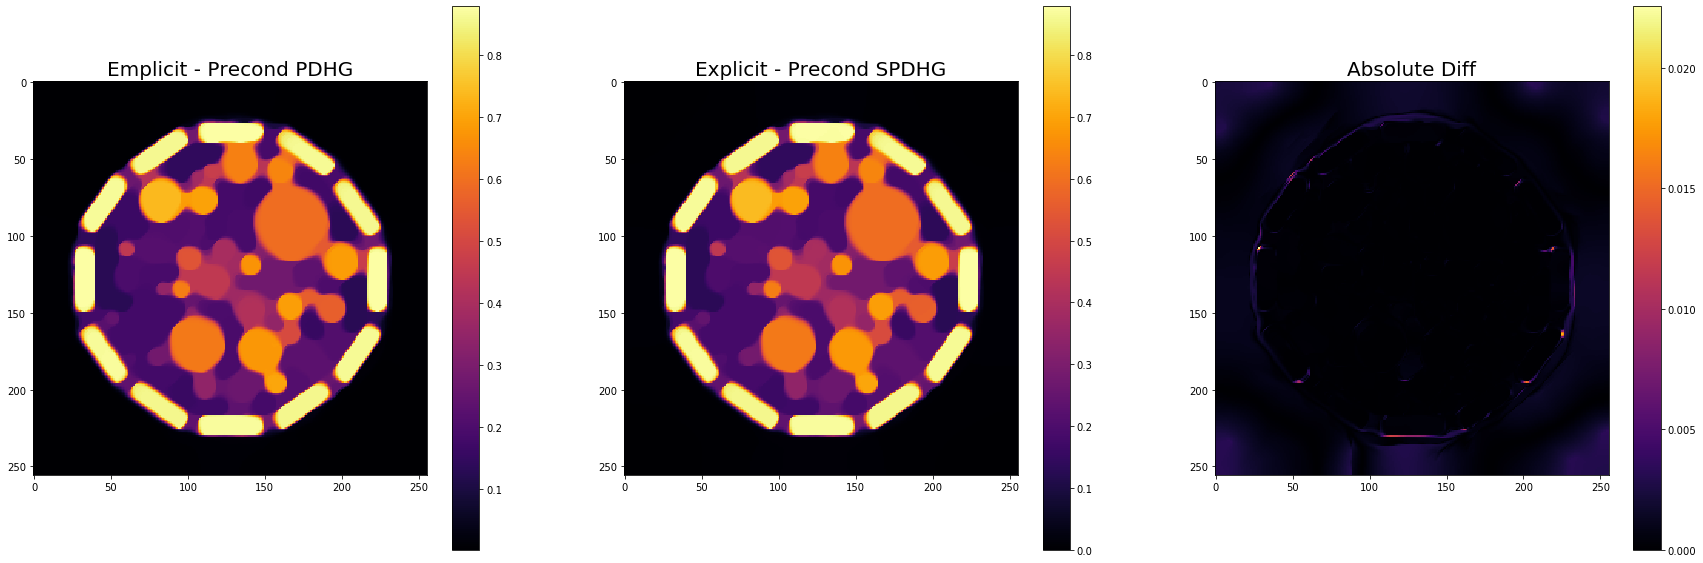

In [8]:

plt.figure(figsize=(30,10))

plt.subplot(1,3,1)
plt.imshow(pdhg_explicit_tv_precond.get_output().as_array(), cmap = 'inferno')
plt.title('Emplicit - Precond PDHG', fontsize=20)
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(spdhg_explicit_tv_precond.get_output().as_array(), cmap = 'inferno')
plt.title('Explicit - Precond SPDHG', fontsize=20)
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow((pdhg_explicit_tv_precond.get_output()-spdhg_explicit_tv_precond.get_output()).abs().as_array(), cmap = 'inferno')
plt.title('Absolute Diff', fontsize=20)
plt.colorbar()
